In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import cm

In [2]:
import matplotlib.animation as anim
import mycolormaps as mycmap
import tools_plotting as to_plot
import cartopy.crs as ccrs
import numpy as np

In [3]:
import time

In [5]:
# Disable a few warnings:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

In [6]:
def update_lon(ds,longitude='lon'):
    ds.coords[longitude] = (ds.coords[longitude] + 180) % 360 - 180
    ds = ds.sortby(ds.lon)
    return ds

In [7]:
path='/scratch/wcq7pz/exp_levante_post/'

In [8]:
import detect_objects as obj
grid_area = xr.open_dataset('gridarea_dom3p5.nc')
grid_area.coords['lon'] = (grid_area.coords['lon'] + 180) % 360 - 180
grid_area = grid_area.sortby(grid_area.lon)

In [9]:
sum_fixedSM_land = xr.open_dataset('../sum_fixedSM_land.nc')

In [10]:
topo5km = xr.open_dataset('../../exp_levante_post/topography_dom03_5km.nc')
topo5km.coords['lon'] = (topo5km.coords['lon'] + 180) % 360 - 180
topo5km  = topo5km.sortby(topo5km.lon)


In [11]:
# Repeat the variable along the time dimension of ds2
ds_topo = topo5km['topography_c'].broadcast_like(sum_fixedSM_land['time'])

In [12]:
ds_area = grid_area['cell_area'].broadcast_like(sum_fixedSM_land['time'])

In [13]:
AB_SM_fixedSM = sum_fixedSM_land.sel(lat=slice(-7,3),lon=slice(-73,-58)).copy()
SESA_SM_fixedSM = sum_fixedSM_land.sel(lat=slice(-24,-14),lon=slice(-65,-50)).copy()

In [14]:
ocs_mask_AB = xr.open_dataset('nMask_control_ocs_AB.nc')

In [15]:
ds_area_ocs = ds_area.sel(time=ocs_mask_AB.time)
AB_SM_fixedSM_ocs = AB_SM_fixedSM.sel(time=ocs_mask_AB.time)

In [16]:
ds_topo_ocs = ds_topo.sel(time=ocs_mask_AB.time)

In [18]:
# Disable a few warnings:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

In [21]:
# Create a function to calculate spatial standard deviations for a given box size
def calculate_std_dev(size,ds,topo):
    
    # Create an empty array to store standard deviations
    std_devs = np.zeros(num_samples)
    box_centers = []  # List to store center points
    # Start measuring the execution time
    start_time = time.time()
    
    for i in range(num_samples):
        # Select a random time index
        time_index = 100; #np.random.randint(0, len(ds.time))
        # Select a random coordinate for the lower-left corner of the box within the domain
        lon_random = np.random.uniform(lon_min, lon_max - size * grid_size)
        lat_random = np.random.uniform(lat_min, lat_max - size * grid_size)
        
        # Calculate the box coordinates
        box_lon_min = lon_random
        box_lon_max = lon_random + size * grid_size
        box_lat_min = lat_random
        box_lat_max = lat_random + size * grid_size


        # Create a mask for the current random box
        box_mask = (
            (ds['lon'] >= box_lon_min) &
            (ds['lon'] <= box_lon_max) &
            (ds['lat'] >= box_lat_min) &
            (ds['lat'] <= box_lat_max)
        )
        if (topo.isel(time=time_index).where(box_mask).median()<500)&(topo.isel(time=time_index).where(box_mask).std()<150):
            
            # Calculate the spatial standard deviation within the box
            std_devs[i] = ds['w_so'].isel(time=time_index).where(box_mask).std()
        else:
            std_devs[i] = np.nan
        # Calculate the center points of the box
        center_lon = (box_lon_min + box_lon_max) / 2
        center_lat = (box_lat_min + box_lat_max) / 2
        box_centers.append((center_lat, center_lon))    

    # Stop measuring the execution time
    end_time = time.time()

    # Calculate the elapsed time
    elapsed_time = end_time - start_time

    print(f"Elapsed time: {elapsed_time} seconds")

    return std_devs, box_centers

In [22]:
grid_size_deg = 0.045

In [25]:
box_sizes_km2 = [10000,40000]; grid_size_deg = 0.045

# Calculate the number of grid points for each box size
num_grid_points = []

for size_km2 in box_sizes_km2:
    # Calculate the number of grid points along one dimension (e.g., latitude or longitude)
    num_points = int(np.sqrt(size_km2 ) / (grid_size_deg*110))

    num_grid_points.append((num_points, num_points))  # Assuming square boxes

# Print the results
for size_km2, num_points in zip(box_sizes_km2, num_grid_points):
    print(f"Box Size: {size_km2} km^2, Number of Grid Points (lat x lon): {num_points[0]} x {num_points[1]}")

Box Size: 10000 km^2, Number of Grid Points (lat x lon): 20 x 20
Box Size: 40000 km^2, Number of Grid Points (lat x lon): 40 x 40


In [26]:
#Bounds
lon_min, lon_max = -73, -58 
lat_min, lat_max = -7, 3 

# Define fixed box sizes in grid points
grid_size = 0.045  # Grid size in degrees
box_size = 40  #  Number of grids in each dimension

# Convert box sizes to degrees
box_sizes_deg = box_size * grid_size 

# Number of random samples
num_samples = 1000

In [29]:
# Apply the function for a single box size
# del(results_fixedSM)
results_fixedSM = calculate_std_dev(box_size, AB_SM_fixedSM_ocs, ds_topo_ocs)
SMstd_fixedSM = results_fixedSM[0]
centers_fixedSM = results_fixedSM[1]

Elapsed time: 7.356119871139526 seconds


In [30]:
# Calculate percentiles and identify indices
percentile_90 = np.nanpercentile(SMstd_fixedSM, 90)
percentile_99 = np.nanpercentile(SMstd_fixedSM, 99)
percentile_10 = np.nanpercentile(SMstd_fixedSM, 10)
percentile_1 = np.nanpercentile(SMstd_fixedSM, 1)

high_std_indices = np.where((SMstd_fixedSM > percentile_90)&(SMstd_fixedSM < percentile_99))[0]
low_std_indices  = np.where((SMstd_fixedSM < percentile_10)&(SMstd_fixedSM > percentile_1))[0]

In [31]:
print(percentile_99,percentile_90,percentile_10,percentile_1)

53.663602256774915 36.6133918762207 15.81933879852295 13.485345840454102


In [33]:
def extract_ocs_area(centers, indices, box_size, ds_area_ocs, ocs_mask_AB, ds_topo, grid_size):
    areas = []
    ngrid = box_size // 2
    
    for idx in indices:
        lat_center, lon_center = centers[idx]
        box_sm = ds_area_ocs.sel(
            lat=slice(lat_center - grid_size * ngrid, lat_center + grid_size * ngrid),
            lon=slice(lon_center - grid_size * ngrid, lon_center + grid_size * ngrid))
        box_topo = ds_topo.sel(
            lat=slice(lat_center - grid_size * ngrid, lat_center + grid_size * ngrid),
            lon=slice(lon_center - grid_size * ngrid, lon_center + grid_size * ngrid))
        area = box_sm.where((ocs_mask_AB.mask_obs > 0)&(box_topo.median()<500)&(box_topo.std()<150)).sum(
            ['lat', 'lon']) / 1e6  # Convert to km^2
        
        areas.append(area)
    
    return np.concatenate(areas)



In [34]:
# Extract areas for high and low std_dev cases
# del(area_fixed_highSM,area_fixed_lowSM)
area_fixed_highSM = extract_ocs_area(centers_fixedSM,
                                     high_std_indices, box_size, ds_area_ocs, ocs_mask_AB, ds_topo_ocs, grid_size)
area_fixed_lowSM = extract_ocs_area(centers_fixedSM, 
                                    low_std_indices, box_size, ds_area_ocs, ocs_mask_AB, ds_topo_ocs, grid_size)


In [35]:
len(area_fixed_highSM[area_fixed_highSM>2500]) ###1000 samples

5609

In [36]:
len(area_fixed_highSM[area_fixed_highSM>2500]) ##500 samples

2930

In [37]:
def get_hist(df, bins):
    hist, _ = np.histogram(df, bins)
    percent = [100*i/sum(hist) for i in hist]
    return percent

In [38]:
bingS = (np.logspace(np.log10(2500),np.log10(2e4),9)); mid_bins = 0.5*(bingS[1:]+bingS[:-1])


In [41]:
outplot = '/scratch/wcq7pz/output_plots/'

In [47]:
def bootstrap_error(data, bins, n_samples):
    samples = np.random.choice(data, (n_samples, len(data)), replace=True)
    histograms = [np.histogram(sample, bins=bins)[0] for sample in samples]
    percentual_frequencies = [100*hist / hist.sum() for hist in histograms]
    return percentual_frequencies

In [48]:
errorbar_props = {'fmt': 'none', 'ecolor': 'dimgrey', 'capsize': 3}

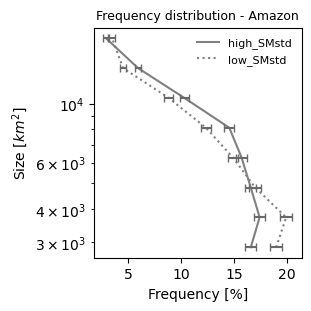

In [54]:
f, axs = plt.subplots(1, 1, figsize=(3, 3),layout='constrained',sharey=True); 
lw=1.5; sample=1000

p1 = get_hist(area_fixed_highSM[area_fixed_highSM>2500],bingS); 
p2 = get_hist(area_fixed_lowSM[area_fixed_lowSM>2500],bingS);
axs.plot(p1, mid_bins,  label='high_SMstd', color='grey');
axs.plot(p2,  mid_bins,  label='low_SMstd', color='grey', ls=':');
axs.set_yscale('log');
axs.set_xlabel('Frequency [%]'); 
axs.set_ylabel('Size [$km ^{2}$]'); 
axs.set_title('Frequency distribution - Amazon',fontsize=9);axs.legend(fontsize=8,frameon=False); 

axs.errorbar(p1, mid_bins, xerr= np.std(bootstrap_error(area_fixed_highSM[area_fixed_highSM>2500], bingS, sample), axis=0), **errorbar_props)
axs.errorbar(p2, mid_bins, xerr= np.std(bootstrap_error(area_fixed_lowSM[area_fixed_lowSM>2500], bingS, sample), axis=0), **errorbar_props)

plt.savefig(outplot+"fig_S2_ylog.pdf", format="pdf",dpi=300,  bbox_inches="tight", transparent=True)